### Documentation

To read more about the search API, visit the [docs.](https://www.elastic.co/docs/explore-analyze/query-filter/languages/querydsl)

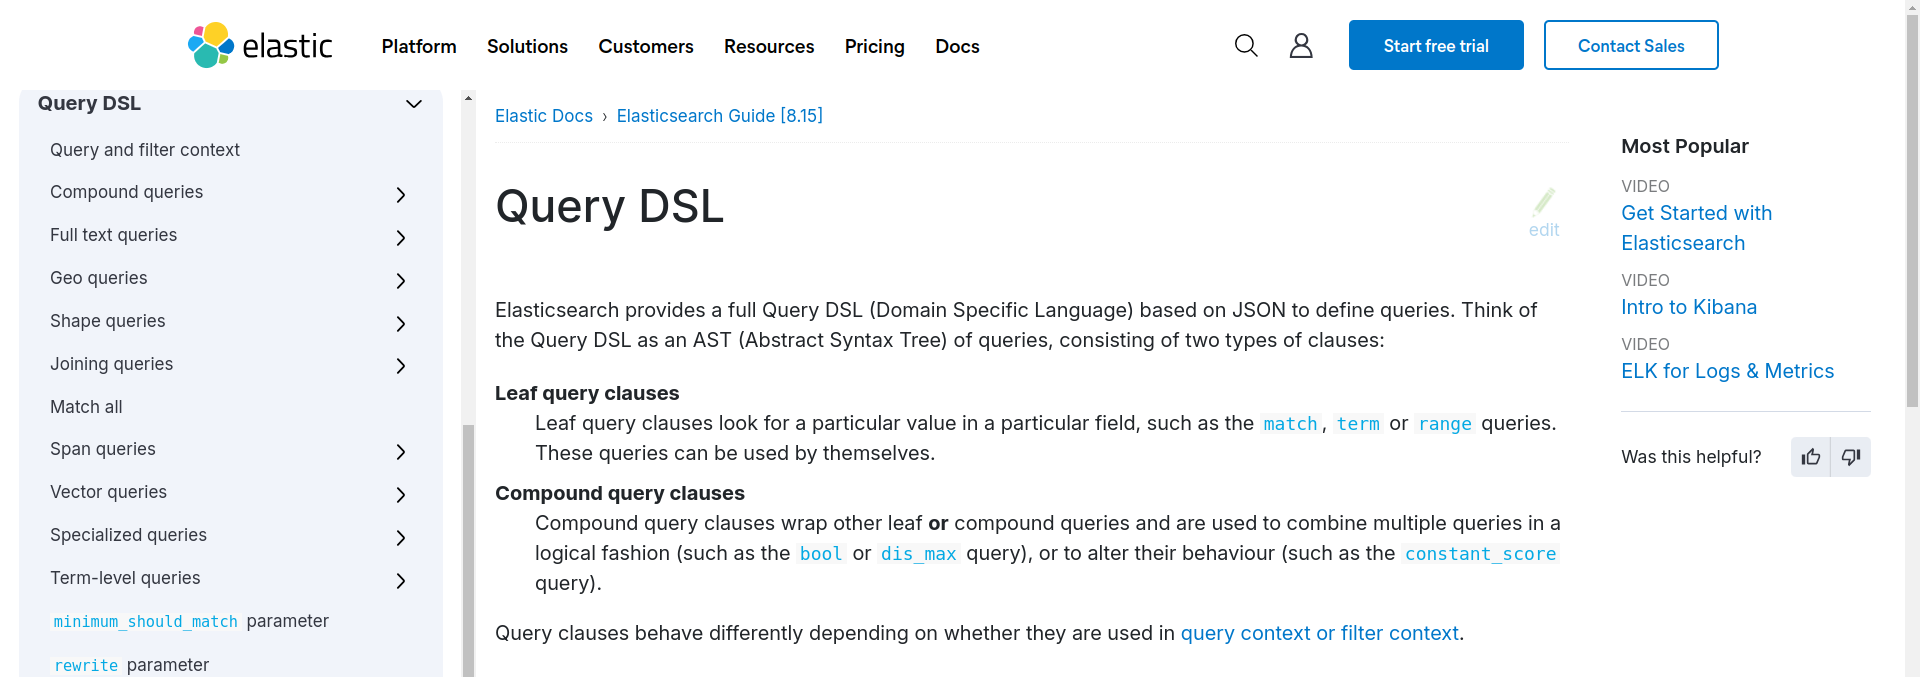

In [2]:
from IPython.display import Image, display

display(Image(filename="../images/query_dsl_docs.png"))

### Connect To ElasticSearch

In [7]:
from pprint import pprint
from elasticsearch import Elasticsearch

es = Elasticsearch('http://localhost:9200')
client_info = es.info()
print('Connected to Elasticsearch!')
pprint(client_info.body)

Connected to Elasticsearch!
{'cluster_name': 'docker-cluster',
 'cluster_uuid': '0cXT2SaPTdGHk8cC2kcjuQ',
 'name': '71a7b5e51874',
 'tagline': 'You Know, for Search',
 'version': {'build_date': '2024-08-05T10:05:34.233336849Z',
             'build_flavor': 'default',
             'build_hash': '1a77947f34deddb41af25e6f0ddb8e830159c179',
             'build_snapshot': False,
             'build_type': 'docker',
             'lucene_version': '9.11.1',
             'minimum_index_compatibility_version': '7.0.0',
             'minimum_wire_compatibility_version': '7.17.0',
             'number': '8.15.0'}}


### Inserting documents

In [8]:
es.indices.delete(index='my_index', ignore_unavailable=True)
es.indices.create(index='my_index')

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'my_index'})

Let's index the documents sequentially.

In [9]:
import json
from tqdm import tqdm

dummy_data= json.load(open("../data/dummy_data.json"))
for document in tqdm(dummy_data, total=len(dummy_data)):
    response = es.index(index='my_index', body=document)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 43.51it/s]


### Searching

### 1. Leaf Clauses

### 1.1. term query

Let's use the Query `DSL` language to construct a query that will find any document that was created on `2024-09-22`

In [10]:
response = es.search(
    index="my_index",
    body={
        "query":{
            "term":{
                "created_on":"2024-09-22",
            }
        }
    }
)

n_hits = response['hits']['total']['value']
print(f"Found {n_hits} documents in my_index")


Found 1 documents in my_index


To retrieve the document just use the `hits` dictionary like this.

In [11]:
retrieved_documents = response['hits']['hits']
retrieved_documents

[{'_index': 'my_index',
  '_id': 'C2kvNpoBcZrE9m9bf_ao',
  '_score': 1.0,
  '_source': {'title': 'Sample Title 1',
   'text': 'This is the first sample document text.',
   'created_on': '2024-09-22'}}]

## 1.2. match query

Now, let's search for any `document` that contains the word document in the text field.

In [12]:
response = es.search(
    index='my_index',
    body={
        "query":{
            "match":{
                "text":"document"
            }
        }
    }
)

n_hits = response['hits']['total']['value']
print(f"Found {n_hits} documents in my_index")


Found 3 documents in my_index


In [13]:
retrieved_documents = response['hits']['hits']
retrieved_documents

[{'_index': 'my_index',
  '_id': 'C2kvNpoBcZrE9m9bf_ao',
  '_score': 0.13606146,
  '_source': {'title': 'Sample Title 1',
   'text': 'This is the first sample document text.',
   'created_on': '2024-09-22'}},
 {'_index': 'my_index',
  '_id': 'DGkvNpoBcZrE9m9bf_bg',
  '_score': 0.13606146,
  '_source': {'title': 'Sample Title 2',
   'text': 'Here is another example of a document.',
   'created_on': '2024-09-24'}},
 {'_index': 'my_index',
  '_id': 'DWkvNpoBcZrE9m9bf_bk',
  '_score': 0.12874341,
  '_source': {'title': 'Sample Title 3',
   'text': 'The content of the third document goes here.',
   'created_on': '2024-09-24'}}]

### 1.3. range query

Let's find documents that were created before `2024-09-24`

In [18]:
response = es.search(
    index='my_index',
    body={
        "query": {
            "range": {
                "created_on": {
                    "lte": "2024-09-23"
                }
            }
        }
    }
)

n_hits = response['hits']['total']['value']
print(f"Found {n_hits} documents in my_index")

Found 1 documents in my_index


In [19]:
retrieved_documents = response['hits']['hits']
retrieved_documents

[{'_index': 'my_index',
  '_id': 'C2kvNpoBcZrE9m9bf_ao',
  '_score': 1.0,
  '_source': {'title': 'Sample Title 1',
   'text': 'This is the first sample document text.',
   'created_on': '2024-09-22'}}]

This is how you use the leaf clauses. Now, if you want to combine leaf clauses together, you do that with the compound clauses.



### 2. Compound clauses

Let's search for documents that meet the following criteria:
- Created on `2024-09-24`
- Have the word `third` in the text field.

In [20]:
response = es.search(
    index='my_index',
    body={
        "query":{
            "bool":{
                "must":[
                    {
                        "match":{
                            "text":"third",
                        }
                    },
                    {
                        "range":{
                            "created_on":{
                                "gte":"2024-09-24",
                                "lte":"2024-09-24",
                            }
                        }
                    }
                ]
            }
        }
    }
)

n_hits = response['hits']['total']['value']
print(f"Found {n_hits} documents in my_index")
                            

Found 1 documents in my_index


In [21]:
retrieved_documents = response['hits']['hits']
retrieved_documents

[{'_index': 'my_index',
  '_id': 'DWkvNpoBcZrE9m9bf_bk',
  '_score': 1.94566,
  '_source': {'title': 'Sample Title 3',
   'text': 'The content of the third document goes here.',
   'created_on': '2024-09-24'}}]

With the compound clause, we were to combine two leaf clauses to find a specific document.